In [1]:
from pathlib import Path
import os
import sys

sys.path.append(Path(os.path.abspath('')).parent.parent)
os.chdir(Path(os.path.abspath('')).parent.parent)

import numpy as np
import pandas as pd 
import xarray as xr
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

import config.settings as cset

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

import geopandas as gpd 
from matplotlib import colormaps as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely import box

labelsize_small  = 13
labelsize_medium = 15
labelsize_large  = 17

## Load and Prepare Data

In [2]:
# loading & preparing gdp data
gdp_df   = pd.read_csv(cset.file_burke).loc[:, ['iso', 'scen', 'run', 'year', 'diff_SSP2', 'SSP2']].loc[:, ['iso', 'scen', 'run', 'year', 'diff_SSP2', 'SSP2']]
gdp_df.loc[gdp_df.scen == 'Ref1p5', 'scen'] = 'Ref'
# only keep data for year that we are interested in: 
gdp_baseline = gdp_df[gdp_df.year == 2015]['SSP2'].values
gdp_df   = gdp_df[(gdp_df.year == cset.gdp_target_year)].copy()
# adding for compatibility with characteristics df s
gdp_df['scen_run'] = gdp_df['scen'] + '_' + gdp_df['run'].astype(str)

# loading & preparing tas_baseline data
tas_df = pd.read_csv(cset.file_tas)
tas_df = tas_df[tas_df.year == 2015].copy()
tas_df = tas_df.rename(columns = {'run': 'scen_run', 'tas': 'tas_soc'})
tas_df = tas_df.dropna(subset=['tas_soc']).groupby('iso').filter(lambda x: x['tas_soc'].notna().all())
tas_df.loc[tas_df['scen_run'].str.contains('Ref_1p5'), 'scen_run'] = tas_df['scen_run'].str.replace('Ref_1p5', 'Ref')

# loading & preparing glmt data 
glmt_char_df = pd.read_csv(cset.path_MESMER_char / 'gmt_characteristics_thsld_150.csv', index_col = 0)

# merge datasets into a single regression dataset
regression_df = gdp_df.loc[:, ['iso', 'scen_run', 'diff_SSP2']].merge(glmt_char_df, left_on='scen_run', right_index=True)
regression_df['GDP_baseline'] = gdp_baseline
regression_df = regression_df.merge(tas_df[['iso', 'scen_run', 'tas_soc']], on=['iso', 'scen_run'], how='left')
#   - add baseline temperature values
regression_df['tas_baseline'] = regression_df.groupby('iso')['tas_soc'].transform('mean')
regression_df['tas_soc']      -= regression_df['tas_baseline']
regression_df                 = regression_df.sort_values(['iso', 'scen_run'])
regression_df['gmt_os']       = regression_df['gmt_max']- regression_df['gmt_eoc']
regression_df['log_gmt_cum']  = np.log(regression_df['gmt_cum'])

regression_df['gmt_delta_eoc'] = 1.5+regression_df['gmt_exc']*2-regression_df['gmt_eoc']
regression_df['gmt_delta_max'] = regression_df['gmt_max']-(1.5+2*regression_df['gmt_exc'])
# clear storage
# del gdp_df, glmt_char_df, tas_df

## Preprocess Regression Variables

In [147]:
# better target variable compared to regression_df['diff_SSP2']
y = np.log(regression_df['diff_SSP2'])

# Define predictor variables (excluding 'iso' and the target variable)
predictors = ['tas_soc', 'tas_baseline', 'gmt_cum', 'gmt_max', 'gmt_eoc', 'gmt_os', 'gmt_od', 'gmt_ud', 'gmt_exc', 'gmt_delta_eoc', 'gmt_delta_max', 'gmt_uxc', 'gmt_max_exc', 'gmt_eoc_exc']
# Generate second-order terms
poly       = PolynomialFeatures(2, interaction_only=False, include_bias=False)
X_poly     = poly.fit_transform(regression_df[predictors])
X_poly_std = StandardScaler().fit_transform(X_poly)
# Extract polynomial feature names
poly_feature_names  = poly.get_feature_names_out(predictors)
predictor_df        = pd.DataFrame(X_poly, columns = poly_feature_names)
regression_df.index = predictor_df.index
# interactions with tas_baseline 
interaction_terms   = [f for f in poly_feature_names if (('tas_baseline' in f) & (f != 'tas_baseline') & (f != 'tas_baseline^2')) | ('gmt_eoc' in f)]
# Combine original predictors, interaction terms, and polynomial features 
all_predictors     = list(predictors) + list(interaction_terms) + list([f+'^2' for f in predictors])
# intercept matrix for country fixed effects  
n_countries = int(len(regression_df)/1000)
X_intercept = np.zeros((len(regression_df), n_countries))
for i in range(n_countries):
    X_intercept[i*1000:(i+1)*1000, i] = 1

## Apply density estimation to final GDP Data 

In [205]:
# load gmt data: 
gmt       = np.zeros((cset.n_scenarios*100, cset.n_years))
columns    = []
fair_ids_100  = pd.read_csv(cset.path_FAIR / 'ids_reconstructed.csv', sep = ',', index_col = 0).drop(columns = ['Ref']).rename(columns={'Ref_1p5': 'Ref'})
for i_scen in range(cset.n_scenarios): 
    scenario = [f.split('_')[0] for f in gdp_df.scen_run[::100*157].values][i_scen]
    all_fair_runs = pd.read_csv(cset.path_FAIR / f'scen_{scenario}.csv', index_col = 0).iloc[:, fair_ids_100.loc[:, scenario].values]
    all_fair_runs.columns = np.arange(100)
    mesmer_ids = xr.load_dataset(cset.path_MESMER_fldmean / f'{scenario}_fldmean.nc')['fair_esm_variability_realisation'].values
    fair_ids_mesmer = [int(f.split('_')[0]) for f in mesmer_ids]
    gmt[i_scen*100:(i_scen+1)*100,:] = all_fair_runs.loc[slice(2015,2100), fair_ids_mesmer].T
    columns.append([scenario + f'_{int(i_run+1)}' for i_run in range(100)])
columns = np.array(columns).flatten()

i_sel_scenarios = [5, 2]
sel_scenarios   = [cset.scenarios[i_sel] for i_sel in i_sel_scenarios]

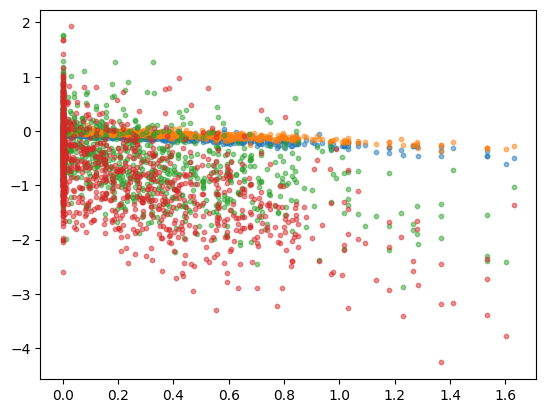

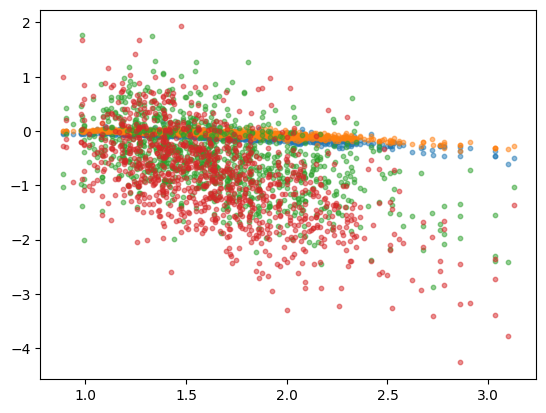

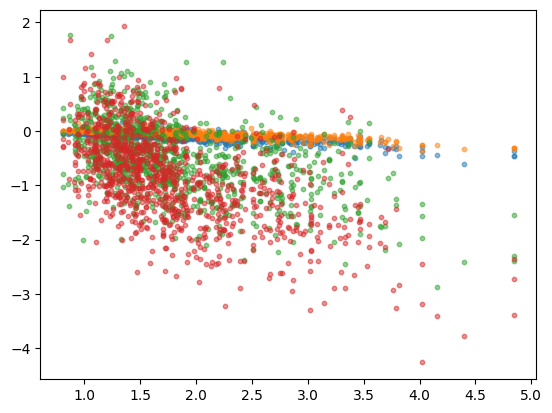

In [241]:
plt.figure()
plt.scatter(regression_df[regression_df.iso == 'AFG'].loc[:, 'gmt_exc'], np.log(regression_df[regression_df.iso == 'AFG'].loc[:, 'diff_SSP2']), s = 10, alpha = .5)
plt.scatter(regression_df[regression_df.iso == 'USA'].loc[:, 'gmt_exc'], np.log(regression_df[regression_df.iso == 'USA'].loc[:, 'diff_SSP2']), s = 10, alpha = .5)
plt.scatter(regression_df[regression_df.iso == 'BGD'].loc[:, 'gmt_exc'], np.log(regression_df[regression_df.iso == 'BGD'].loc[:, 'diff_SSP2']), s = 10, alpha = .5)
plt.scatter(regression_df[regression_df.iso == 'MLI'].loc[:, 'gmt_exc'], np.log(regression_df[regression_df.iso == 'MLI'].loc[:, 'diff_SSP2']), s = 10, alpha = .5)
plt.show()
plt.figure()
plt.scatter(regression_df[regression_df.iso == 'AFG'].loc[:, 'gmt_cum'], np.log(regression_df[regression_df.iso == 'AFG'].loc[:, 'diff_SSP2']), s = 10, alpha = .5)
plt.scatter(regression_df[regression_df.iso == 'USA'].loc[:, 'gmt_cum'], np.log(regression_df[regression_df.iso == 'USA'].loc[:, 'diff_SSP2']), s = 10, alpha = .5)
plt.scatter(regression_df[regression_df.iso == 'BGD'].loc[:, 'gmt_cum'], np.log(regression_df[regression_df.iso == 'BGD'].loc[:, 'diff_SSP2']), s = 10, alpha = .5)
plt.scatter(regression_df[regression_df.iso == 'MLI'].loc[:, 'gmt_cum'], np.log(regression_df[regression_df.iso == 'MLI'].loc[:, 'diff_SSP2']), s = 10, alpha = .5)
plt.show()
plt.figure()
plt.scatter(regression_df[regression_df.iso == 'AFG'].loc[:, 'gmt_eoc'], np.log(regression_df[regression_df.iso == 'AFG'].loc[:, 'diff_SSP2']), s = 10, alpha = .5)
plt.scatter(regression_df[regression_df.iso == 'USA'].loc[:, 'gmt_eoc'], np.log(regression_df[regression_df.iso == 'USA'].loc[:, 'diff_SSP2']), s = 10, alpha = .5)
plt.scatter(regression_df[regression_df.iso == 'BGD'].loc[:, 'gmt_eoc'], np.log(regression_df[regression_df.iso == 'BGD'].loc[:, 'diff_SSP2']), s = 10, alpha = .5)
plt.scatter(regression_df[regression_df.iso == 'MLI'].loc[:, 'gmt_eoc'], np.log(regression_df[regression_df.iso == 'MLI'].loc[:, 'diff_SSP2']), s = 10, alpha = .5)
plt.show()

## Fit model and estiamte marginal effect

In [225]:
sel_predictors = ['tas_soc', 'tas_soc tas_baseline', 'gmt_eoc', 'tas_baseline gmt_eoc', 'gmt_exc', 'tas_baseline gmt_exc']
# sel_predictors = ['tas_soc', 'tas_soc tas_baseline', 'gmt_eoc', 'tas_baseline gmt_eoc', 'gmt_cum', 'tas_baseline gmt_cum', 'gmt_cum gmt_eoc']
# sel_predictors = ['tas_soc', 'tas_soc tas_baseline', 'gmt_cum', 'tas_baseline gmt_cum', 'gmt_cum gmt_eoc']
# sel_predictors = ['tas_soc', 'tas_soc tas_baseline', 'gmt_eoc', 'tas_baseline gmt_eoc', 'gmt_cum', 'tas_baseline gmt_cum']

country_data = regression_df[regression_df.tas_baseline >= 12].copy()
country_data.loc[:, 'run'] = [int(f.split('_')[1]) for f in country_data['scen_run'].values]
y_country     = np.log(country_data['diff_SSP2'].values)

X_country_raw = predictor_df.loc[regression_df.tas_baseline >= 12, sel_predictors].copy()
X_country     = X_country_raw.values.copy()
X_train       = X_country[country_data.run < 70,:].copy()
y_train       = y_country[country_data.run < 70].copy()
X_test        = X_country[country_data.run >= 70,:].copy()
y_test        = y_country[country_data.run >= 70].copy()

X_intercept_train = X_intercept[regression_df.tas_baseline >= 12][country_data.run < 70,:].copy()
X_intercept_test = X_intercept[regression_df.tas_baseline >= 12][country_data.run >= 70,:].copy()

linreg = LinearRegression(fit_intercept=False).fit(np.c_[X_train, X_intercept_train], y_train)
print('Train score: ', linreg.score(np.c_[X_train, X_intercept_train], y_train), 'Test score: ', linreg.score(np.c_[X_test, X_intercept_test], y_test))

Train score:  0.9139516204371889 Test score:  0.9052017340500359


In [218]:
# load gmt data: 
gmt       = np.zeros((cset.n_scenarios*100, cset.n_years))
columns    = []
fair_ids_100  = pd.read_csv(cset.path_FAIR / 'ids_reconstructed.csv', sep = ',', index_col = 0).drop(columns = ['Ref']).rename(columns={'Ref_1p5': 'Ref'})
for i_scen in range(cset.n_scenarios): 
    scenario = cset.scenarios[i_scen]
    all_fair_runs = pd.read_csv(cset.path_FAIR / f'scen_{scenario}.csv', index_col = 0).iloc[:, fair_ids_100.loc[:, scenario].values]
    all_fair_runs.columns = np.arange(100)
    mesmer_ids = xr.load_dataset(cset.path_MESMER_fldmean / f'{scenario}_fldmean.nc')['fair_esm_variability_realisation'].values
    fair_ids_mesmer = [int(f.split('_')[0]) for f in mesmer_ids]
    gmt[i_scen*100:(i_scen+1)*100,:] = all_fair_runs.loc[slice(2015,2100), fair_ids_mesmer].T
    columns.append([scenario + f'_{int(i_run+1)}' for i_run in range(100)])
columns = np.array(columns).flatten()

i_sel_scenarios = [5, 2]
sel_scenarios   = [cset.scenarios[i_sel] for i_sel in i_sel_scenarios]

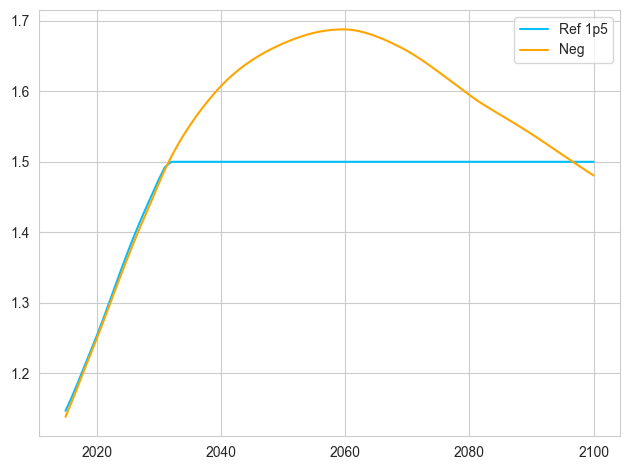

In [219]:
# trjajectories that end close to 1.5 and start between 1.1 and 1
gmt_ref = np.mean(gmt[500:600, :], axis = 0)
gmt_neg = np.mean(gmt[200:300, :], axis = 0)
gmt_ref[17:] = 1.5
with sns.axes_style('whitegrid'):
    plt.figure()
    plt.plot(np.linspace(2015, 2100, 86), gmt_ref, color = '#00BFFF', label = 'Ref 1p5') 
    plt.plot(np.linspace(2015, 2100, 86), gmt_neg, color = '#FFA500', label = 'Neg')
    plt.legend()
    plt.tight_layout()
    plt.show()

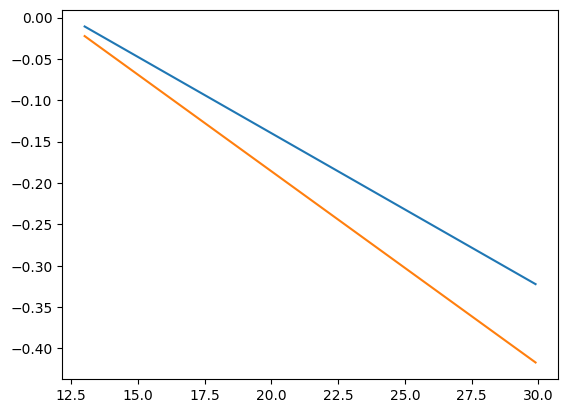

In [226]:
def compute_exc(gmt):
    gmt_tmp       = (gmt-1.5).copy()
    gmt_tmp[gmt_tmp < 0] = 0
    gmt_exc       = gmt_tmp.sum()/86
    # gmt_tmp     = gmt-(gmt[-1])
    # gmt_tmp[gmt_tmp < 0] = 0
    # gmt_od   = gmt_tmp.sum() 
    gmt_cum = gmt.sum()/86
    return(gmt_exc)

T_baseline = np.arange(13,30,0.1)
eoc        = 1.5
exc_ref    = compute_exc(gmt_ref)
exc_neg    = compute_exc(gmt_neg)

# pred_ref = np.array([[0,0] + [eoc, eoc*t] + [exc_ref, exc_ref*t, eoc*exc_ref] + [0]*157 for t in T_baseline])
# pred_neg = np.array([[0,0] + [eoc, eoc*t] + [exc_neg, exc_neg*t, eoc*exc_neg] + [0]*157 for t in T_baseline])
pred_ref = np.array([[0,0] +   [eoc, eoc*t]+ [exc_ref, exc_ref*t]+ [0]*157 for t in T_baseline])
pred_neg = np.array([[0,0] +   [eoc, eoc*t]+ [exc_neg, exc_neg*t] + [0]*157 for t in T_baseline])

impact_ref = linreg.predict(pred_ref)
impact_neg = linreg.predict(pred_neg)

plt.figure()
plt.plot(T_baseline, impact_ref)
plt.plot(T_baseline, impact_neg)
plt.show()

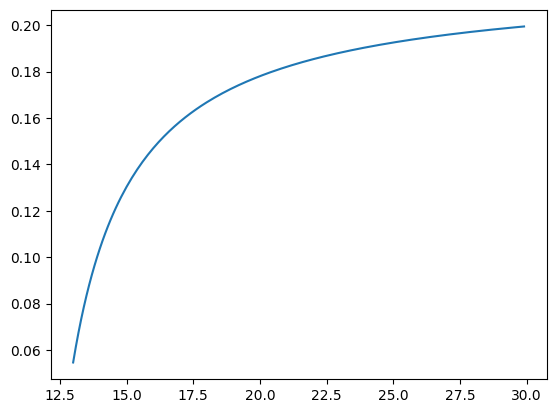

In [227]:
plt.figure()
plt.plot(T_baseline, (linreg.coef_[2]+linreg.coef_[3]*T_baseline)/(linreg.coef_[4]+linreg.coef_[5]*T_baseline))
plt.show()

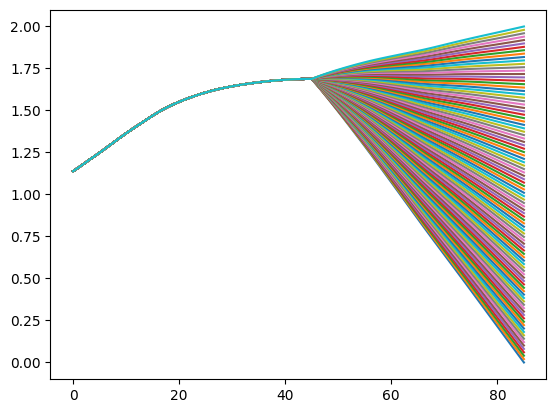

In [228]:
x         = np.linspace(2015, 2100, 86)
p         = np.polyfit([2060, 2100], [gmt_neg[45], gmt_neg[-1]], 1)
y_lin_og  = p[0]*x + p[1]
# plt.figure()
# plt.plot(gmt_neg)
# plt.plot(y_lin_og)
# plt.show()

# x_Ts = np.arange(5,30.05,0.05)
x_eocs = np.linspace(0,2,100)

EXCs = []
# for x_eoc in np.arange(10**,-1,-0.01):
plt.figure()
for x_eoc in x_eocs:
    x         = np.linspace(2015, 2100, 86)
    p         = np.polyfit([2060, 2100], [gmt_neg[45], x_eoc], 1)
    y_lin     = p[0]*x + p[1]
    
    gmt_neg_adj      = gmt_neg.copy()
    gmt_neg_adj[45:] += y_lin[45:] - y_lin_og[45:]
    plt.plot(gmt_neg_adj)
    
    EXCs.append(compute_exc(gmt_neg_adj))
plt.show()

In [230]:
IMPACTS_NEG = []
for i, x_eoc in enumerate(x_eocs):
    # pred_tmp = np.array([[0,0] + [x_eoc, x_eoc*t] + [EXCs[i], EXCs[i]*t, x_eoc*EXCs[i]] + [0]*157 for t in T_baseline])
    pred_tmp = np.array([[0,0] + [x_eoc, x_eoc*t] + [EXCs[i], EXCs[i]*t] + [0]*157 for t in T_baseline])
    IMPACTS_NEG.append(linreg.predict(pred_tmp))

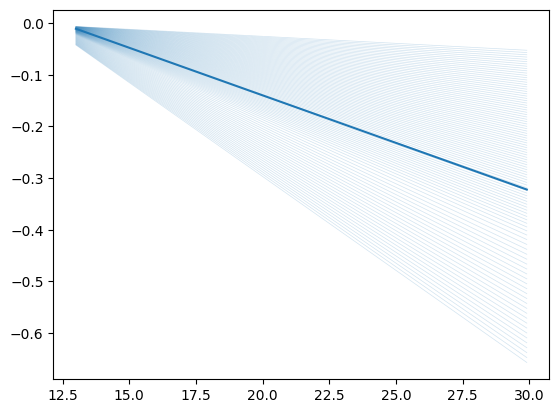

In [231]:
plt.figure()
plt.plot(T_baseline, np.array(IMPACTS_NEG).T, color = 'C0', alpha = .2, lw = 0.5)
plt.plot(T_baseline, impact_ref)
plt.show()

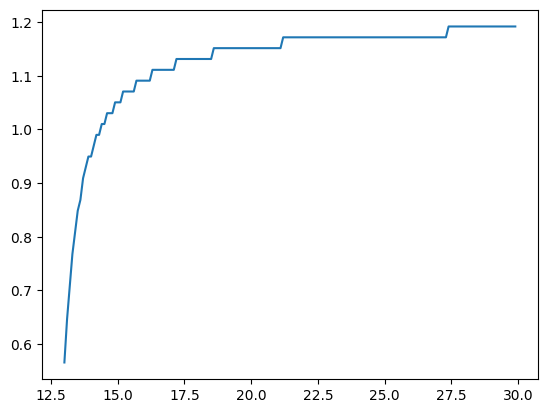

In [232]:
idx_min = np.abs(np.array(IMPACTS_NEG)-impact_ref).argmin(axis = 0)
plt.figure()
plt.plot(T_baseline, x_eocs[idx_min])
# plt.axvline(11.9)
plt.show()

In [233]:
gmt_trajectories_equal = []

for i in range(len(T_baseline)): 
    idx    = idx_min[i]
    x_eoc  = x_eocs[idx]
    
    x         = np.linspace(2015, 2100, 86)
    p         = np.polyfit([2060, 2100], [gmt_neg[45], x_eoc], 1)
    y_lin     = p[0]*x + p[1]

    gmt_neg_adj      = gmt_neg.copy()
    gmt_neg_adj[45:] += y_lin[45:]-y_lin_og[45:]
    
    gmt_trajectories_equal.append(gmt_neg_adj)
    
gmt_trajectories_equal = np.array(gmt_trajectories_equal)

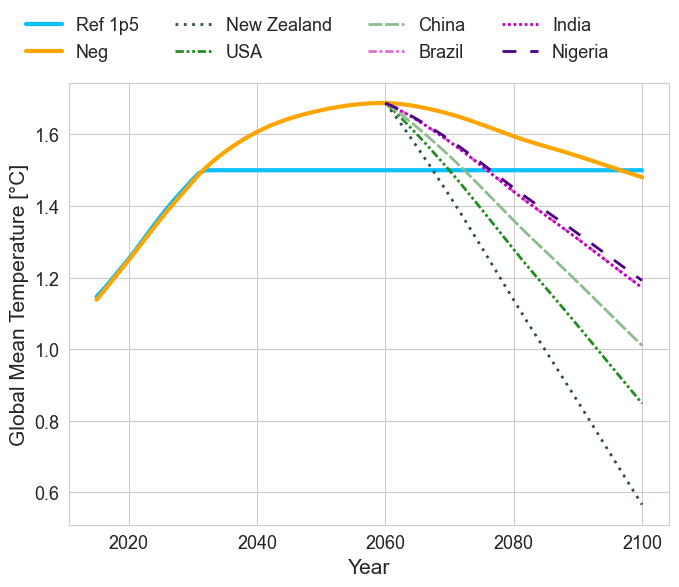

In [234]:
from matplotlib.colors import LinearSegmentedColormap
#new zealand (NZL) is pretty much zero 
focus_countries         = ['NZA', 'USA', 'CHN', 'BRA', 'IND', 'NGA']
focus_countries_names   = ['New Zealand', 'USA', 'China', 'Brazil', 'India', 'Nigeria']
focus_temperatures      = [regression_df[regression_df.iso == country].loc[:, 'tas_baseline'].mean() for country in focus_countries] 
# Create a custom colormap
colors = ['indigo',
          'm', 
          'orchid',
          'darkseagreen',
          'forestgreen',
          'darkslategrey'
          ] 
custom_cmap = LinearSegmentedColormap.from_list('OrangeYellowGreen', colors[::-1], N=256)
focus_colours = custom_cmap(np.linspace(0,1,6))

focus_linestyles        = [ (0,(1, 2)), (0, (3, 1, 1, 1, 1, 1)), (0, (5,1)), (0,(3, 1, 1, 1)), (0, (1,1)), (0, (5,5))] 
idx_country = [np.abs(T_baseline-focus_temperatures[i_country]).argmin() for i_country in range(len(focus_countries))]
with sns.axes_style('whitegrid'):
    with sns.axes_style('whitegrid'):
        plt.figure(figsize = (7,6))
        plt.plot(np.linspace(2015,2100,86), gmt_ref, color = '#00BFFF', linewidth = 3, label = 'Ref 1p5')
        plt.plot(np.linspace(2015,2100,86), gmt_neg, color = '#FFA500', linewidth = 3, label = 'Neg')
        # lc  = multiline(np.array([np.linspace(2015,2100,86)[45:] for i in range(501-150)]),  gmt_trajectories_equal[150:, 45:], x_Ts[150:], cmap='RdBu_r', lw=2, alpha =.1)
        for i_country in range(len(focus_countries)):
            plt.plot(np.linspace(2015,2100,86)[45:], gmt_trajectories_equal[idx_country[i_country], 45:], color = focus_colours[i_country], label = focus_countries_names[i_country], linewidth = 2, linestyle = focus_linestyles[i_country])
        plt.tick_params(labelsize = 13)
        plt.xlabel('Year', fontsize = 15)
        plt.ylabel('Global Mean Temperature [°C]', fontsize = 15)
        plt.legend(ncols = 4, loc  = 'center left', frameon = False, bbox_to_anchor=(-0.1, 1.1), fontsize = 13)
        plt.tight_layout()
        plt.show()

EXCs